# Comparing Hadamard Quantum Walks and Original Galton Box Distributions

### Overview
This notebook combines the implementation of a Hadamard quantum walk (Deliverable 5) with its comparison against the standard Galton box behavior (Deliverable 6). The focus is on how quantum interference modifies the output distribution.

### Goals
- Construct circuits for both the Hadamard quantum walk and the classical Galton box.
- Run simulations under identical settings.
- Use statistical distances and visual inspection to compare the outputs.
- Identify qualitative and quantitative differences.


[✓] Plot saved to: ../outputs/Derivable3_extension/comparison_glaton_box_vs_quantum_walk.png


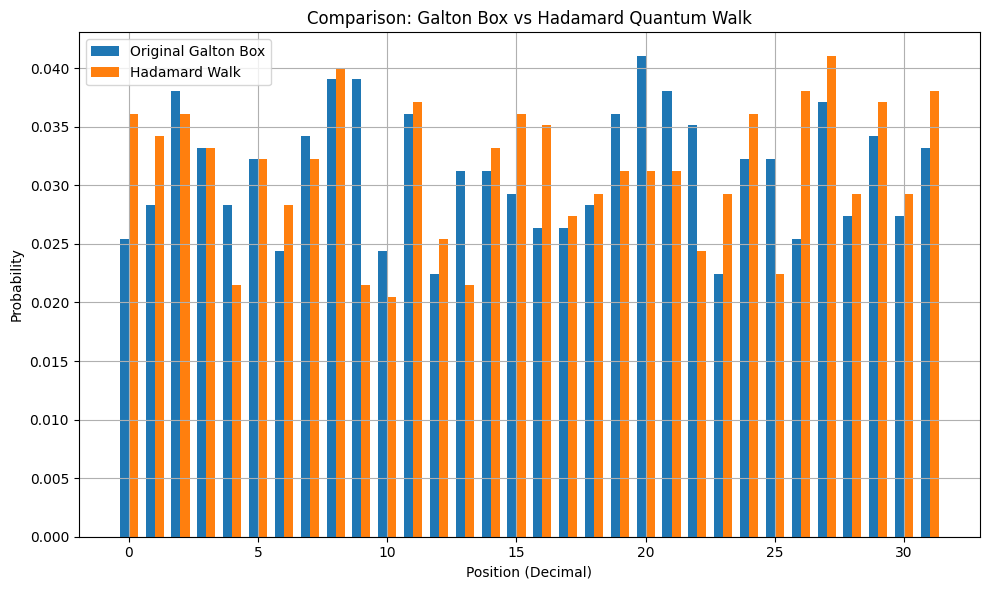


KL Divergence (Hadamard || Galton): 0.0235


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

import os
# Create output directory
output_dir = "../outputs/Derivable3_extension/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist

# -----------------------------------------------
# Step 1: Build Hadamard Quantum Walk Circuit
# -----------------------------------------------
def build_hadamard_walk(n_layers: int):
    """
    Builds a Hadamard quantum walk circuit without intermediate measurements,
    simulating coherent evolution across all layers.

    Args:
        n_layers (int): Number of layers in the walk (also number of position qubits).

    Returns:
        QuantumCircuit: The Hadamard walk quantum circuit.
    """
    coin = QuantumRegister(1, name='coin')
    position = QuantumRegister(n_layers, name='pos')
    c = ClassicalRegister(n_layers, name='c')
    qc = QuantumCircuit(coin, position, c)

    for i in range(n_layers):
        qc.h(coin[0])                 # Hadamard coin toss (superposition)
        qc.cx(coin[0], position[i])   # Shift operation

    qc.measure(position, c)
    return qc

# -----------------------------------------------
# Step 2: Convert bitstring results to positions
# -----------------------------------------------
def convert_counts_to_positions(counts):
    positions = {}
    for bitstring, count in counts.items():
        pos = int(bitstring, 2)
        positions[pos] = positions.get(pos, 0) + count
    return positions

# -----------------------------------------------
# Step 3: Plot comparison between Galton and Hadamard
# -----------------------------------------------
def compare_distributions(galton_counts, hadamard_counts, n_layers=5, shots=1024, save_path=None):
    galton_pos = convert_counts_to_positions(galton_counts)
    hadamard_pos = convert_counts_to_positions(hadamard_counts)

    x_vals = sorted(set(galton_pos.keys()) | set(hadamard_pos.keys()))
    galton_probs = np.array([galton_pos.get(x, 0)/shots for x in x_vals])
    hadamard_probs = np.array([hadamard_pos.get(x, 0)/shots for x in x_vals])

    plt.figure(figsize=(10,6))
    width = 0.35
    plt.bar(np.array(x_vals)-width/2, galton_probs, width=width, label='Original Galton Box')
    plt.bar(np.array(x_vals)+width/2, hadamard_probs, width=width, label='Hadamard Walk')
    plt.xlabel('Position (Decimal)')
    plt.ylabel('Probability')
    plt.title('Comparison: Galton Box vs Hadamard Quantum Walk')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # if save_path:
    #     plt.save_fig(save_path, dpi=300)
    # plt.show()
    plot_path = os.path.join(output_dir, "comparison_glaton_box_vs_quantum_walk.png")
    plt.savefig(plot_path, dpi=300)
    print(f"[✓] Plot saved to: {plot_path}")
    plt.show()
    
    # KL divergence (for optional quantitative analysis)
    kl_div = entropy(hadamard_probs + 1e-10, galton_probs + 1e-10)
    print(f"\nKL Divergence (Hadamard || Galton): {kl_div:.4f}")

# -----------------------------------------------
# Step 4: Run Simulations
# -----------------------------------------------
def run_simulation():
    n_layers = 5
    shots = 1024

    # Build Galton Box circuit (from previous task)
    def build_galton_box(n_layers):
        coin = QuantumRegister(1, name='coin')
        position = QuantumRegister(n_layers, name='pos')
        c = ClassicalRegister(n_layers, name='c')
        qc = QuantumCircuit(coin, position, c)
        for i in range(n_layers):
            qc.h(coin[0])
            qc.cx(coin[0], position[i])
        qc.measure(position, c)
        return qc

    galton_qc = build_galton_box(n_layers)
    hadamard_qc = build_hadamard_walk(n_layers)

    sim = AerSimulator()
    galton_compiled = transpile(galton_qc, sim)
    hadamard_compiled = transpile(hadamard_qc, sim)

    galton_result = sim.run(galton_compiled, shots=shots).result()
    hadamard_result = sim.run(hadamard_compiled, shots=shots).result()

    galton_counts = galton_result.get_counts()
    hadamard_counts = hadamard_result.get_counts()
  
    compare_distributions(galton_counts, hadamard_counts, n_layers=n_layers, shots=shots)

    
    # plot_path = os.path.join(output_dir, "comparison_glaton_box_vs_quantum_walk.png")
    # print(f"[✓] Plot saved to: {plot_path}")

# Run the comparison
run_simulation()
